<br><br><font color="gray">DOING COMPUTATIONAL SOCIAL SCIENCE<br>MODULE 6 <strong>PROBLEM SETS</strong></font>

# <font color="#49699E" size=40>Latent Factors and Text Analysis</font>
This module notebook assignment is organized into two parts. 

- **[PART A](#SECAEP) (Accompanying Chapter 9, "Latent Factors, Dimensions, and Classes")**
    - [Exercises and Practice Problems](#SECAEP) (All students)
- **[PART B](#SECBEP) (Accompanying Chapter 10, "Processing Language Data"**)
    - [Exercises and Practice Problems](#SECBEP) (All students)

# What You Need to Know Before Getting Started

- **You can consult any resources you want when completing these exercises and problems**. Just as it is in the "real world:" if you can't figure out how to do something, look it up. My recommendation is that you check the relevant parts of the assigned reading or search for inspiration on [https://stackoverflow.com](https://stackoverflow.com).
- **Each problem is worth 1 point**. All problems are equally weighted.
- **The information you need for each problem set is provided in the blue and green cells.** General instructions / the problem set preamble are in the blue cells, and instructions for specific problems are in the green cells. **You have to execute all of the code in the problem set, but you are only responsible for entering code into the code cells that immediately follow a green cell**. You will also recognize those cells because they will be incomplete. You need to replace each `____` with the code that will make the cell execute properly.
- **The comments in the problem cells contain clues indicating what the following line of code is supposed to do.** Use these comments as a guide when filling in the blanks. 
- **Each problem cell stores one object named according to the problem (e.g. _09)**. These are not important for you, but we use them to help grade your work efficiently, so **do not delete them or change their names**. If you do, you will lose marks.
- **You can ask for help**. If you run into problems, you can reach out to John (john.mclevey@uwaterloo.ca) or Pierson (pbrowne@uwaterloo.ca) for help. You can ask a friend for help if you like, regardless of whether they are enrolled in the course.

Finally, remember that you do not need to "master" this content before moving on to other course materials, as what is introduced here is reinforced throughout the rest of the course. You will have plenty of time to practice and cement your new knowledge and skills.

# How to Submit Your (Pickled) Assignment! 

Since we've had to rethink the way we deliver, collect, and evaluate these problem sets, we want to be very clear about what you need to do to properly submit this module notebook assignment. Please read the following explanation of our process so that you understand how this works, and what you need to do.

At the very end of this notebook, there is a code cell that will compile all of your answers to every problem in the assignment and save them as a 'pickle' file (`.pkl`) in the current working directory. You can execute that cell as many times as you like. Each time you run it, it will overwrite the old pickle with your updated answers. **Once you've ensured that everything in the notebook is complete and finished to your satisfaction, it's up to you to get the pickle that you just created and upload it to the appropriate Learn dropbox for this module.** The file you are looking for will not exist until you run the cells at the end of the notebook. Once it has been created, it will follow this naming convention: 

> `module_[number]__student_[your_student_number].pkl`

To be very clear, **you need to submit the pickle to Learn**. You do not need to upload the Jupyter Notebook as initially planned. **Just the pickle!**

## Make Sure Everything is Good to Go

It's generally a good idea to do a 'fresh' run of your entire notebook before you submit your assignment to make sure that everything is working as it should be. You can use the button with the 'Fast-Forward' arrows in the Jupyter toolbar above to restart the kernel (resetting everything to initial conditions) and running every code cell in the notebook, in order. You can also select 'Restart and Run All' from the Kernel dropdown menu. If the entire notebook runs without throwing any errors, you should be good to go!

If you're running into issues, make sure that you haven't changed any of the 'answer' variable names we provided you with (e.g., we asked you to store your answer to the first question in a variable called `_01`). If you change an answer's variable name or don't store your answer in that variable, the project won't finalize properly and you won't get proper credit for your work. The same goes for the `student_id` metadata variable we ask you to complete immediately below; if any of those are missing, haven't been filled in properly, or have been renamed, issues may arise during the grading process and you will not receive proper credit. So make sure you enter your student information, and don't delete or change the names of the variables that store your answers to each problem!

## IMPORTANT: ADD YOUR STUDENT ID NUMBER

<div class="alert alert-block alert-danger">
To evaluate your work, we need you to provide your student number. In the cell below, <strong>replace '12345678' with your student number</strong>. The student_id' variable needs to be an integer, so <strong>do not wrap it in quotes.</strong>
</div>

In [1]:
# Your UWaterloo student ID number
student_id = 20611274 

## Package and Data Imports

In [2]:
import os
from posixpath import join

import pandas as pd
import numpy as np
from scipy.stats import zscore
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import spacy
from gensim.models.phrases import Phrases, Phraser

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint


years = list(range(2017, 2020))

columns = [
    'speechtext', 
    'speakername', 
    'speakerparty', 
    'speakerriding', 
    'speakeroldname']

hansard_paths = []

for year in years:
    for root, dirs, files in os.walk(f"data/canadian_hansards/{year}/"):
        for file in files:
            hansard_paths.append(join(root, file))
    
hansards = []

for filename in hansard_paths:
    df = pd.read_csv(filename, index_col=None, header=0, usecols=columns).dropna(subset=['speechtext', 'speakername', 'speakerparty'])
    hansards.append(df)

can_df = pd.concat(hansards, axis=0, ignore_index=True)#.sample(replace=False, frac=.1, random_state=23)

evs_df = pd.read_stata(
    "data/european_values_study/ZA7500_v4-0-0.dta",
    convert_categoricals=False,
    columns = [
        # Overview
        #'country',
        
        # Religion and Morale
        'v54', # Religious services? - 1=More than Once Per Week, 7=Never
        'v64', # How often do you pray? - 1=More than Once Per Week, 7=Never
        'v149', # Do you justify: claiming state benefits? - 1=Never, 10=Always
        'v150', # Do you justify: cheating on tax? - 1=Never, 10=Always 
        'v151', # Do you justify: taking soft drugs? - 1=Never, 10=Always 
        'v152', # Do you justify: taking a bribe? - 1=Never, 10=Always 
        'v153', # Do you justify: homosexuality? - 1=Never, 10=Always 
        'v154', # Do you justify: abortion? - 1=Never, 10=Always 
        'v155', # Do you justify: divorce? - 1=Never, 10=Always 
        'v156', # Do you justify: euthanasia? - 1=Never, 10=Always 
        'v157', # Do you justify: suicide? - 1=Never, 10=Always 
        'v158', # Do you justify: having casual sex? - 1=Never, 10=Always 
        'v159', # Do you justify: public transit fare evasion? - 1=Never, 10=Always 
        'v160', # Do you justify: prostitution? - 1=Never, 10=Always 
        'v161', # Do you justify: artificial insemination? - 1=Never, 10=Always 
        'v162', # Do you justify: political violence? - 1=Never, 10=Always 
        'v163', # Do you justify: death penalty? - 1=Never, 10=Always 
        
        # Politics and Society
        'v97', # Interested in Politics? - 1=Interested, 4=Not Interested
        'v121', # How much confidence in Parliament? - 1=High, 4=Low
        'v124', # How much confidence in EU? - 1=High, 4=Low
        'v126', # How much confidence in Health Care System? - 1=High, 4=Low
        'v142', # Importance of Democracy - 1=Unimportant, 10=Important
        'v143', # Democracy in own country - 1=Undemocratic, 10=Democratic
        'v145', # Political System: Strong Leader - 1=Good, 4=Bad
        'v146', # Political System: Experts Making Decisions - 1=Good, 4=Bad
        'v147', # Political System: Army Rules the Country - 1=Good, 4=Bad
        'v148', # Political System: Democratic - 1=Good, 4=Bad
        'v208', # How often follow politics on TV? - 1=Daily, 5=Never
        'v211', # How often follow politics on Social Media? - 1=Daily, 5=Never
        
        # National Identity
        'v170', # How proud are you of being a citizen? - 1=Proud, 4=Not Proud
        'v184', # Immigrants: impact on development of country - 1=Bad, 5=Good
        'v185', # Immigrants: take away jobs from Nation - 1=Take, 10=Do Not Take
        'v198', # European Union Enlargement - 1=Should Go Further, 10=Too Far Already
        
        # Socio-demographics
        'v226', # Year of Birth by respondent 
        'v227', # Respondent Born in Country - 1=Yes, 2=No
        'v261_ppp', # Household Monthly Net Income, PPP-Corrected
    ])

just_country = pd.read_stata(
    "data/european_values_study/ZA7500_v4-0-0.dta",
    columns = ['country'],
)

evs_df[evs_df < 0] = np.nan

evs_df['country'] = list(just_country['country'])

evs_df = evs_df.dropna()

country_index = evs_df['country'].to_numpy()

print(evs_df['country'].value_counts())

evs_df = evs_df.drop("country", axis=1)

Denmark                   2804
Switzerland               2142
Netherlands               1476
Georgia                   1333
Great Britain             1237
Bosnia and Herzegovina    1204
Germany                   1198
Italy                     1186
France                    1130
Iceland                   1122
Albania                   1026
Croatia                    963
Armenia                    960
Austria                    959
Finland                    947
Sweden                     865
Norway                     865
Hungary                    849
Czechia                    803
Romania                    748
Slovakia                   710
Serbia                     708
Belarus                    702
Russia                     699
Azerbaijan                 681
Poland                     666
Slovenia                   663
Bulgaria                   625
Lithuania                  588
Spain                      535
North Macedonia            524
Estonia                    478
Monteneg

# <font color="#49699E">PART A | CHAPTER 9</font>
<a id="SECAEP"></a>


## Question 1:
<div class="alert alert-block alert-info">  
In Part A of this assignment, we're going to be working with data from the European Values Survey (EVS). The data is comprised of data collected by interviewers, and was drawn from most European nations in 2017. In the (intimidatingly large) import cell above, we took the liberty of loading the data for you and removing all of the rows contianing missing data. There's also a breakdown of how many responses come from each country.
</div>
<div class="alert alert-block alert-info">  
As established in the first of the two chapters you read this week, standardized data is a <i>sine qua non</i> when working with latent variables!
</div>
<div class="alert alert-block alert-success">
Standardize the data present in the columns of the <code>evs_df</code> variable. Submit the standardized data.
</div>

In [3]:
#_01

# Standardize the data
X = StandardScaler().fit_transform(evs_df)

print(X)

# Store the result in the assignment variable
_01 = X # do not change this variable name

[[-0.51929643 -1.43422015 -0.55068206 ... -0.29719112 -0.2123977
  -1.19367471]
 [-0.51929643 -0.6054601  -0.55068206 ... -1.16587324 -0.2123977
  -0.92939721]
 [ 1.08698673 -1.43422015 -0.55068206 ...  0.45566672 -0.2123977
  -1.19367471]
 ...
 [-0.51929643  1.05205999  0.98823344 ...  0.45566672 -0.2123977
   1.54702386]
 [ 1.08698673  1.05205999 -0.55068206 ...  0.33984244 -0.2123977
  -0.26643672]
 [-0.51929643  0.22329994 -0.55068206 ...  0.22401816 -0.2123977
   1.54702386]]


## Question 2:
<div class="alert alert-block alert-info">  
Just like in the chapter, we'll proceed with our now-standardized by producing a principal components analysis. Unlike in the chapter, however, we're only going to have our PCA return the top 10 components.
</div>
<div class="alert alert-block alert-success">
Perform a principal components analysis on the standardizd EVS data. Only return the top 10 components (sorted in order of explained variance ratio). Submit a numpy array containing the explained variance ratios of the 10 principal components you found. 
</div>

In [4]:
#_02

# Create PCA with 10 components
pca = PCA(n_components=10, random_state=42)

# Fit the PCA
pca.fit_transform(X)

# Extract explained variance ratio
evr = pca.explained_variance_ratio_

print(evr)

# Store the result in the assignment variable
_02 = evr # do not change this variable name

[0.17373927 0.09943049 0.0602953  0.05135182 0.04102094 0.03653924
 0.03238552 0.03157131 0.02873046 0.02788947]


## Question 3:
<div class="alert alert-block alert-info">  
Although the process of interpreting screeplots is generally subjective and open to interpretation, we're fortunate in that the screeplot from our PCA of the EVS data has a clear inflection point. It's time to flex your interpretation muscles! 
</div>
<div class="alert alert-block alert-success">
Produce a screeplot of the 10 principal components you produced in question 2. Submit an integer corresponding to the principal component ID that corresponds with the inflection point.
</div>

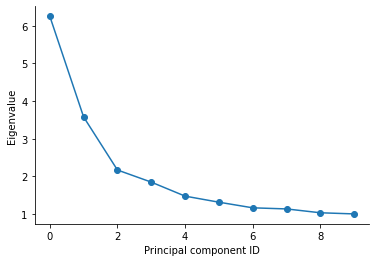

In [5]:
#_03

# Extract explained variances
eigenvalues = pd.Series(pca.explained_variance_)

# Create screeplot
fig, ax = plt.subplots()
sns.lineplot(x=eigenvalues.index, y=eigenvalues, data=eigenvalues)
plt.scatter(x=eigenvalues.index, y=eigenvalues)
ax.set(xlabel='Principal component ID', ylabel='Eigenvalue')
sns.despine()
plt.show()

inflection_point = 2

# Store the result in the assignment variable
_03 = inflection_point # do not change this variable name

## Question 4:
<div class="alert alert-block alert-info">  
In the following code cell, we're going to ask you to perform a K-means cluster with a K of 10, AND to write a function capable of telling us a bit more about the nationalities of the individuals from each cluster. That's a lot of code for you to write, but don't be intimidated: you can treat this as two separate problems that you need to solve sequentially (consider commenting out all of the hint code regarding the function while you're working on creating the K-means analysis).
</div>
<div class="alert alert-block alert-success">
Perform a K-means cluster analysis, where K = 10, on the EVS data. Store the labels from your K-means cluster analysis in the 'cluster' variable (provided for you). Then, write a function that zips together your list of cluster assignments and the list of countries from the EVS data (both should be the same length), and then iterates over this zipped list in order to create a dictionary where each key is a cluster number (0 through 9) and each value is a list of the 5 nationalities that most frequently appear in that cluster. We have provided a screenshot of what the result should look like (based on the pprint function call we've given you). Submit what your function returns . 
</div>

In [6]:
#_04

# Set number of clusters
num_clusters = 10

# Instantiate k-means 
km = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)

# Fit instantiated k-means to data
k_means_fitted = km.fit(X)

# Extract clusters
clusters = k_means_fitted.labels_.tolist() # Do not change this line

# Write function for summarizing results of k-means clustering
def top_countries_by_cluster(
    km, 
    num_clusters, 
    country_index, 
    return_top = 5):

    # Create zipped list of k-means labels and the country column from original dataset
    cluster_countries = list(zip(km.labels_, country_index))
    
    # Initialize cluster dictionary
    cluster_count = {i:{} for i in range(num_clusters)}

    # Iterate over cluster-country pairs:
    for pair in cluster_countries:
        
        # Extract cluster and country
        cluster_num = pair[0]
        country = pair[1]

        # Retrieve current count of particular nationality in cluster
        current_count = cluster_count[cluster_num].get(country, 0)
        
        # Increment count by one 
        current_count += 1
        
        # Store incremented count as new value 
        cluster_count[cluster_num][country] = current_count
    
    # Sort the values of the cluster dictionary and filter down to 5 most common nationalities for each cluster
    for cluster_num, country_dict in cluster_count.items():
        cluster_count[cluster_num] = sorted(country_dict, key=lambda x: country_dict[x], reverse=True)[0:return_top]

    # Return final count dictionary
    return cluster_count

        
pprint(top_countries_by_cluster(k_means_fitted, num_clusters, country_index))
    
    
# Store the result in the assignment variable
_04 = top_countries_by_cluster(k_means_fitted, num_clusters, country_index) # do not change this variable name

{0: ['Switzerland', 'Denmark', 'Italy', 'Austria', 'Germany'],
 1: ['Armenia', 'Belarus', 'Russia', 'Lithuania', 'Georgia'],
 2: ['Russia', 'Slovakia', 'Spain', 'France', 'Czechia'],
 3: ['Switzerland', 'Denmark', 'Netherlands', 'Germany', 'Great Britain'],
 4: ['Georgia', 'Serbia', 'Bosnia and Herzegovina', 'Croatia', 'Hungary'],
 5: ['Denmark', 'Great Britain', 'Netherlands', 'Czechia', 'France'],
 6: ['Denmark', 'Iceland', 'Switzerland', 'Norway', 'Sweden'],
 7: ['Albania', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Georgia'],
 8: ['Switzerland', 'Denmark', 'Great Britain', 'Croatia', 'Germany'],
 9: ['Georgia', 'Armenia', 'Azerbaijan', 'Bosnia and Herzegovina', 'Romania']}


## Question 5:
<div class="alert alert-block alert-info">  
In question 4, you familiarized yourself with K-means clustering and built a function capable of summarizing some of your results. Of course, the number of clusters we used above was arbitrary, and might be nowhere close to the optimal number of clusters needed for the data. In this question, we're going to use silhouette analysis to determine a good number of centroids to cluster the data around. It's highly likely that our silhouette analysis will indicate that 2 or 3 clusters is optimal, but since we want to tease out regional variations, we'll insist on finding an optimal solution using more than 4 clusters.
</div>
<div class="alert alert-block alert-success">
Using silhouette analysis, find an optimal number of clusters for the EVS data that's greater than 4 and less than 11. Submit the K value you have decided to use (as an integer). If the silhouette analysis was conducted properly, there should be a clear best option.
</div>

4 clusters:
0.07582821298335198


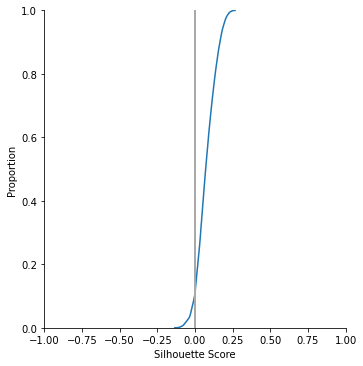

5 clusters:
0.06303225014072325


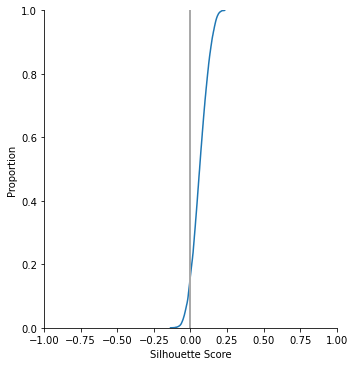

6 clusters:
0.0646645749526502


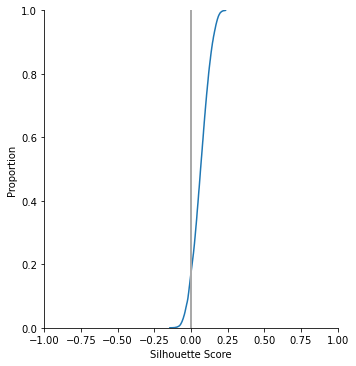

7 clusters:
0.05519129972298155


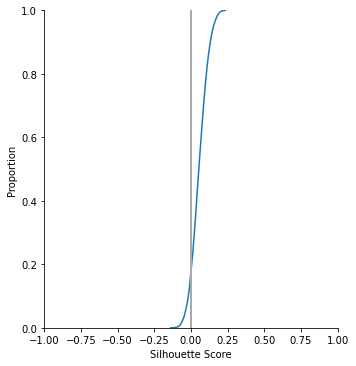

8 clusters:
0.04769236305569307


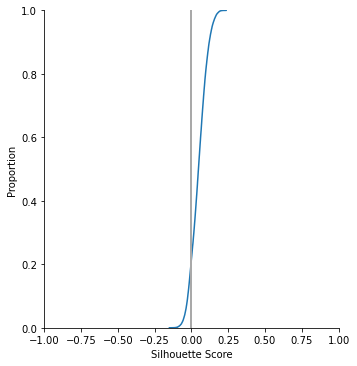

9 clusters:
0.04641737003262641


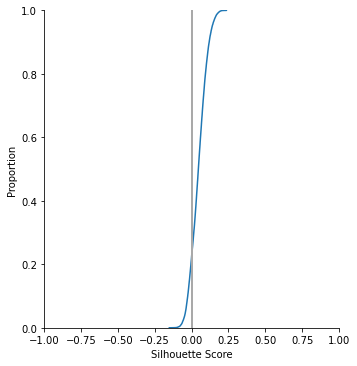

10 clusters:
0.04531394549724758


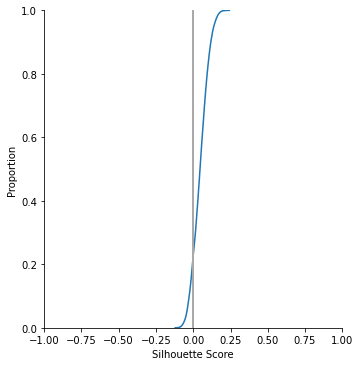

In [7]:
#_05

# Iterate over appropriate range of clusters
for i in range(4, 11):
    
    # Extract value of iterator for consistency 
    num_clusters = i

    # Run k-means with iterated number of clusters (see question 4 for detailed breakdown)
    km = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    k_means_fitted = km.fit(X)
    clusters = k_means_fitted.labels_.tolist() # Do not change this line
    
    # Print cluster number
    print(f"{i} clusters:")

    # Print silhouette score
    print(silhouette_score(X, clusters, metric='euclidean'))

    # Extract silhouette samples
    samples = silhouette_samples(X, clusters)

    # Plot extracted samples
    ax = sns.displot(samples, kind="ecdf")
    ax.set(xlabel='Silhouette Score')
    sns.despine()
    plt.xlim(-1, 1)
    plt.axvline(x=0, linewidth=2, color='darkgray')
    plt.show()

# Provide integer value corresponding to the number of clusters you have decided to use
final_number_of_clusters = 4
    
# Store the result in the assignment variable
_05 = final_number_of_clusters # do not change this variable name

## Question 6:
<div class="alert alert-block alert-info">  
Now that we've used silhouette to determine the optimal number of clusters from within a given range, we'll re-perform the cluster analysis and use the function you wrote in question 4 to summarize the results! Then, it's up to you to write a two-sentence analysis of the results. Do you notice any problems or peculiarities with the results? If you do (and you should), write a further two sentences describing the issue(s) you noticed and how you might go about fixing them. 
</div>
<div class="alert alert-block alert-success">
Perform a K-means analysis of the EVS data using the K value determined in question 5. Then, use your function from question 4 to extract the 5 countries which appear most frequently in each cluster. Write two sentences inside the docstring analyzing the results. Write another two sentences detailing obvious improvements that could be implemented to increase the quality of the results (examine the results of the `value_counts()` method performed on the 'country' column; you can find this in the final cell of the 'Package and Data Imports' section above).  
</div>

In [8]:
#_06

# Extract number of clusters from previous question and store in new variable for consistency
num_clusters = final_number_of_clusters

# Perform k-means with selected number of clusters
km = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
k_means_fitted = km.fit(X)
clusters = k_means_fitted.labels_.tolist() # Do not change this line

# Print results
pprint(top_countries_by_cluster(k_means_fitted, num_clusters, country_index))
    
analysis = """

It appears that the highest silhouette score is 0.0758 for 4 clusters, meaning that
observations are close to or on the boundary between neighboring clusters (overlap).

While the result is positive (i.e. relatively correct cluster assignment), results can be improved
by discarding anomalies/outliers, filtering noise, or increasing k within a different range.
"""

# Store the result in the assignment variable
_06 = analysis # do not change this variable name

{0: ['Denmark', 'Switzerland', 'Great Britain', 'Czechia', 'Hungary'],
 1: ['Russia', 'Belarus', 'Slovakia', 'France', 'Spain'],
 2: ['Georgia', 'Albania', 'Armenia', 'Bosnia and Herzegovina', 'Azerbaijan'],
 3: ['Denmark', 'Switzerland', 'Netherlands', 'Iceland', 'Norway']}


# <font color="#49699E">PART B | CHAPTER 10</font>
<a id="SECAEP"></a>

## Question 7:
<div class="alert alert-block alert-info">  
For this second half of the assignment, we're going to turn our attention to the Canadian Hansards. To save you the trouble of having to work with the entire set of Hansards from 2017 through to 2020, we're going to filter them down to only include speeches by federal party leaders present in the House of Commons. Once that's done, we'll run the entire set of speeches through spaCy's nlp pipe, which will prepare us for the subsequent sections!
</div>
<div class="alert alert-block alert-success">
Using the provided list of filter keywords, filter the Canadian Hansard dataframe so that each row consists of a speech by one of the leaders of the Federal Political Parties over the last two years. Put the text of the speeches through spaCy's nlp pipeline using the .pipe() method. Submit the part of speech of the first word of the speech at index 250 of the resulting list of processed speeches.
</div>

In [9]:
#_07

filter_terms = [
    "Justin Trudeau", # Prime Minister, 2015-Present; Leader of the Liberal Party of Canada, 2013-Present
    "Andrew Scheer", # Leader of the Official Opposition, 2017-2019
    "Mario Beaulieu", # Interim Leader of the Bloc Quebequois, 2018-2019
    "Jagmeet Singh", # Leader of the New Democratic Party, 2017-Present
    "Elizabeth May", # Leader of the Green Party of Canada, 2006-2019
    "PPC", # Maxime Bernier in his capacity as Leader of the People's Party of Canada, 2018-Present 
]

# Instantiate list for dataset subsets
leader_speeches = []

# Iterate over filter_terms, filter dataset to term, and store resulting dataframe subset in 'leader_speeches'
for t in filter_terms:
    h = can_df[can_df["speakeroldname"].str.contains(t, na=False)]
    leader_speeches.append(h)

# Concatenate dataframes in 'leader_speeches'
leader_df = pd.concat(leader_speeches, axis=0, ignore_index=True)

# Initialize nlp pipeline, taking care to disable named entity recognition
nlp = spacy.load('en_core_web_sm', disable=["ner"])

# Use list comprehension to feed each speech through spaCy's nlp pipe
corpus = [nlp(speech) for speech in leader_df['speechtext']]

# Extract part of speech from the first word of the speech at index 250
speech_250_pos = corpus[250][0].pos_

pprint(speech_250_pos)

# Store the result in the assignment variable
_07 = speech_250_pos # do not change this variable name

'PROPN'


## Question 8:
<div class="alert alert-block alert-info">  
Now that we have our output from spaCy, we have access to a wealth of information about each word in our dataset. We'll start by using this information to create a list of lists, where the outer list contains a number of inner lists, and each of the inner lists represents a single speech. We'll populate those inner lists with the lemmatized forms of all the nouns and proper nouns present in their corresponding speeches.   
</div>
<div class="alert alert-block alert-success">
Iterate over the docs to create a list of lists, where the outer list represents the documents and the inner list contains a list of lemmatized nouns and proper nouns. Submit the list of lemmatized nouns and proper nouns associated with the speech located at index 500 of the resulting list of speeches.
</div>

In [10]:
#_08

# Populate list containing desired parts of speech
filter_list = ["NOUN", "PROPN"]

# Initialize list for containing results
lemma_list = []

# Iterate over speeches
for speech in corpus:
    # Iterate over each word in speech, add the lemmatized word if it matches one of the desired parts of speech
    lemma_list.append([n.lemma_ for n in speech if n.pos_ in filter_list])

    
# Extract speech from corpus at index 500
speech_500 = lemma_list[500]

pprint(speech_500)
    
# Store the result in the assignment variable
_08 = speech_500 # do not change this variable name

['Mr.',
 'Speaker',
 'commitment',
 'passenger',
 'bill',
 'right',
 'airline',
 'passenger',
 'traveller',
 'country',
 'issue',
 'Canadians',
 'work',
 'Transport',
 'Minister',
 'industry',
 'advocacy',
 'group',
 'citizen',
 'time',
 'passenger',
 'bill',
 'right',
 'passenger']


## Question 9:
<div class="alert alert-block alert-info">  
The solution to this question is going to be very similar to that of the previous question. The major difference here is that we're going to add two new types of token to our inner lists: verbs and adjectives.
</div>
<div class="alert alert-block alert-success">
Iterate over the docs to create a list, where the outer list represents the documents and the inner list contains a list of lemmatized nouns, proper nouns, verbs, and adjectives. Submit the list of lemmatized nouns, proper nouns, verbs, and adjectives associated with the speech located at index 750 of the resulting list of speeches.
</div>

In [11]:
#_09

# Populate list containing desired parts of speech
filter_list = ["NOUN", "PROPN", "VERB", "ADJ"]

# Initialize list for containing results
lemma_list_2 = []

# Iterate over speeches
for speech in corpus:
    # Iterate over each word in speech, add the lemmatized word if it matches one of the desired parts of speech
    lemma_list_2.append([n.lemma_ for n in speech if n.pos_ in filter_list])

speech_750 = lemma_list_2[750]
    
pprint(speech_750)

# Store the result in the assignment variable
_09 = speech_750 # do not change this variable name

['Mr.',
 'Speaker',
 'concerned',
 'impact',
 'job',
 'loss',
 'worker',
 'family',
 'acknowledge',
 'excellent',
 'work',
 'do',
 'Davie',
 'employee',
 'regard',
 'other',
 'shipbuilding',
 'project',
 'strategy',
 'allocate',
 'competitive',
 'project',
 'grant',
 'canadian',
 'shipyard',
 'Davie',
 'last',
 'question',
 'would',
 'like',
 'wish',
 'merry',
 'Christmas',
 'happy',
 'holiday',
 'let',
 'come',
 'safe',
 'sound']


## Question 10:

<div class="alert alert-block alert-info">  
One of the more useful parsing options spaCy provides is robust sentence detection, which is often useful for downstream tasks and sometimes even required. One of those tasks is the bigram detection implementation in gensim. Because bigrams are usually common phrases, they often end up being some kind of topic, even if it's not the core topic of the text. In these next problems, you will create a list of the most frequently occurring bigrams for each political leader. 
</div>
<div class="alert alert-block alert-success">
Using the corpus object you created earlier, create a flat list of all of the tokenized sentences in order to train a gensim Phrases model. While you're at it, use the leader_speeches list of dataframes to prepare a nested list of tokenized speech sentences for each political leader, which you will apply the trained bigram model on. Submit the first sentence by the first leader.
</div>

In [12]:
#_10

# Initialize list for storing results
sent_list = []

# Iterate over speeches in corpus
for speech in corpus:
    # iterate over the sentences in each speech, and then the tokens from each of those sentences...
    # ... add each token to 'sent_list' *as individual words, not lists*.
    # sent_list.append([[token.text for token in sent] for sent in speech.sents]) - errors with Phrases
    for sent in speech.sents:
        for token in sent:
            sent_list.append(token.text)

# Initialize list for storing results
leader_sent_lists = []

# Iterate over the separate leader-specific dataframes in the 'leader_speeches' variable (created in question 7)
for df in leader_speeches:
    
    # Initialize list for storing results within the loop 
    leader_sents = []
    
    # Run the individual dataframe (from the loop) through spacy's nlp pipe and iterate over the results
    for speech in df['speechtext']:
        
        # iterate over the sentences in the speech, and then the tokens from each of those sentences...
        # ... add each token to 'sent_list' *as individual words, not lists*.
        leader_sents.extend([[token.text for token in sent] for sent in nlp(speech).sents])
        
    # Add the 'leader_sents' list to 'leader_sent_lists' *as a list*
    leader_sent_lists.append(leader_sents)

# Retrieve the first sentence spoken by the first leader in the list of lists.
first_sent = leader_sent_lists[0][0]

pprint(first_sent)

# Store the result in the assignment variable
_10 = first_sent # do not change this variable name

['Mr.',
 'Speaker',
 ',',
 'we',
 'have',
 'heard',
 'the',
 'concerns',
 'of',
 'Canadians',
 'across',
 'the',
 'country']


## Question 11:

<div class="alert alert-block alert-info">  
Now we can train a model and use it on the text for each leader!
</div>
<div class="alert alert-block alert-success">
Using the sentences in the corpus, train a gensim Phrases model. Apply that model to the list that contains the list of sentences for each leader. Submit the bigrammed first sentence of the first speech.
</div>

In [13]:
#_11

# Train the model using the data from Question 10
model = Phrases(sent_list, min_count=1, threshold=0.75,
                    scoring='npmi')  # train the model
    
# Create the model applicator
bigrammer = Phraser(model)

# Initialize list
bigrammed_list = []

# Iterate over the lists in the leader_sent_lists object
for sent_list in leader_sent_lists:
    
    # Initialize in-loop list
    bigrammed_sents = []
    
    # Iterate over each sentence in 'sent_list'
    for sent in sent_list:
        
        # Subscript the bigrammer with the sentence and store result 
        bigrammed_sent = bigrammer[sent]
        
        # Add the bigrammed sentence to list of bigrammed sentences
        bigrammed_sents.append(bigrammed_sent)
    
    # Add list of bigrammed sentences from leader to 'bigrammed_list'
    bigrammed_list.append(bigrammed_sents)
    
# Extract first sentence from first leader in list of lists ('bigrammed_list') 
first_sent = bigrammed_list[0][0]

pprint(first_sent)

# Store the result in the assignment variable
_11 = first_sent # do not change this variable name

['Mr.',
 'Speaker',
 ',',
 'we',
 'have',
 'heard',
 'the',
 'concerns',
 'of',
 'Canadians',
 'across',
 'the',
 'country']


## Question 12:

<div class="alert alert-block alert-info">  
Given that the speeches in your list of lists should - if everything went according to plan - appear in the same order as they did in the list of dataframes we used at the beginning of this part, you should be able to match up the list of bigrammed sentences to tell who's doing the talking. 
</div>

<div class="alert alert-block alert-success">
Print the 10 most common bigrams for each leader using a Pandas series. Hint: each leader has a list of tokenized sentences, where each sentence is a list of tokens and bigram tokens are two words joined by "_". Submit the name of the leader that talked about Donald Trump a lot.
</div>

In [14]:
#_12

# Zip together 'filter_terms' and 'bigrammed_list', and iterate over them
for leader, sent_list in zip(filter_terms, bigrammed_list):
    
    # Initialize list
    bigrams = []
    
    # Iterate over sentences in sentence list (from bigrammed_list)
    for sent in sent_list:    
        
        # Iterate over tokens in sentence and extract bigrams...
        # ... which can be identified by the presence of an underscore '_' ...
        # ... and add them to the 'bigrams' list *as a list* 
        bigrams.extend([token for token in sent if '_' in token])
        
    # Convert list of bigrams into a pandas series
    bigram_series = pd.Series(bigrams)
    
    # Print the leader's top ten most-spoken bigrams
    print(leader + '\n')
    print(bigram_series.head()[:10])
    print('\n')

# Write down the name of the leader who talks about Donald Trump with disproportionate frequency! 
trump_talker = 'Elizabeth May'

# Store the result in the assignment variable
_12 = trump_talker.upper() # do not change this variable name

Justin Trudeau

Series([], dtype: float64)


Andrew Scheer

Series([], dtype: float64)


Mario Beaulieu

Series([], dtype: float64)


Jagmeet Singh

Series([], dtype: float64)


Elizabeth May

0    W_SÁNEC
1    W_SÁNEC
2    W_SÁNEC
3    HÍSW_?E
4    W_SÁNEC
dtype: object


PPC

Series([], dtype: float64)




<ipython-input-14-d07772db77b4>:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  bigram_series = pd.Series(bigrams)


In [15]:
## FINALIZE ASSIGNMENT

import pickle as pkl

module = 6

response_dict = {
    "student_id": student_id,
    "grad_student": "EA_undergrad",
    "module": module,
    "responses": [
        _01,
        _02,
        _03,
        _04,
        _05,
        _06,
        _07,
        _08,
        _09,
        _10,
        _11,
        _12,
    ],
    "code_cells": In
}

module_string = f"module_{response_dict['module']}"
filename = f"{module_string}__student_{student_id}.pkl"

with open(f"./{filename}", 'wb') as stream:
    pkl.dump(response_dict, stream)